# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

Key steps:

  -Initialize the parameters of the model

  -Learn the parameters for the model by minimizing the cost  

  -Use the learned parameters to make predictions (on the test set)
  
  -Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [2]:
# sigmoid

def sigmoid(z):
    
    s = 1./(1.+np.exp(-z))
    
    return s

### Initializing parameters



In [3]:
# initialize_with_zeros

def initialize_with_zeros(dim):

    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [4]:
# propagate

def propagate(w, b, X, Y):

    m = X.shape[1]
    #print(w.T.shape)
    A = sigmoid(np.dot(w.T,X)+b )                                 
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)  
    
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [5]:
def propagate_adam(w, b, X, Y, Vw_prev, Sw_prev, Vb_prev, Sb_prev, i):

    betta_1, betta_2 = 0.9, 0.999
    
    grads, cost = propagate(w, b, X, Y)
      
    Vw = Vw_prev*betta_1 + (1-betta_1)*grads['dw']
    Sw = Sw_prev*betta_2 + (1-betta_2)*grads['dw']**2

    Vb = Vb_prev*betta_1 + (1-betta_1)*grads['db']
    Sb = Sb_prev*betta_2 + (1-betta_2)*grads['db']**2

    Vw_corr = Vw/(1-betta_1**(i+1))
    Sw_corr = Sw/(1-betta_2**(i+1))

    Vb_corr = Vb/(1-betta_1**(i+1))
    Sb_corr = Sb/(1-betta_2**(i+1))
    
    grads = {"Vw": Vw_corr,
             "Vb": Vb_corr,
             "Sw": Sw_corr,
             "Sb": Sb_corr}
    
    return grads, cost

### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [6]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, optimizer, print_cost = False):

    costs = []
    Vw, Sw, Vb, Sb = 0, 0, 0, 0
    E = 1e-08
    
    for i in range(num_iterations):
                
        if optimizer == 'SGD':
            
            for j in range(X.shape[1]):
                
                sample_x = X[:, j].reshape(-1,1)
                sample_y = Y[:, j]

                grads, cost = propagate(w,b,sample_x, sample_y)

                # Retrieve derivatives from grads
                dw = grads["dw"]
                db = grads["db"]

                # update rule
                w -=learning_rate*dw
                b -=learning_rate*db
                
            
        elif optimizer == 'GD':
            
            grads, cost = propagate(w,b,X,Y)
            
            # Retrieve derivatives from grads
            dw = grads["dw"]
            db = grads["db"]

            # update rule
            w -=learning_rate*dw
            b -=learning_rate*db
            
        elif optimizer == 'Adam':

            grads, cost = propagate_adam(w,b,X, Y, Vw, Sw, Vb, Sb, i)

            Sw_corr, Vw_corr = grads["Sw"], grads["Vw"] 
            Sb_corr, Vb_corr = grads["Sb"], grads["Vb"]
            
            w -=learning_rate*Vw_corr/(Sw_corr**0.5+E)
            b -=learning_rate*Vb_corr/(Sb_corr**0.5+E)
            
        # Record the costs
        if i % 50 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w,
              "b": b}

#     grads = {"dw": dw,
#              "db": db}
    
    return params, costs

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. 

In [7]:
# predict

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction


Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [8]:
# model

def model(X_train, Y_train, X_test, Y_test, optimizer, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, optimizer, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [9]:
"""Function to plot the performance"""

def plotting(model, name):
    plt.plot(model[0]['costs'], label = 'Lr = 0.01')
    plt.plot(model[1]['costs'], label = 'Lr = 0.001')
    plt.plot(model[2]['costs'], label = 'Lr = 0.0001')
    plt.plot(model[3]['costs'], label = 'Lr = 0.00001')
    plt.plot(model[4]['costs'], label = 'Lr = 0.000001')
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.title(f'Logistic regression with {name}')
    plt.legend()
    plt.show()

Run the following cell to train your model.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('./bioresponse.csv')
X = df.drop("Activity", axis = 1)
Y = df[['Activity']]
x_train, x_test, y_train, y_test = train_test_split(X.values, 
                                                    Y.values, test_size = .25,
                                                    random_state = 41)

In [11]:
x_train = x_train.T
x_test = x_test.T

y_train = y_train.reshape(-1,1).T
y_test = y_test.reshape(-1,1).T

print(x_train.shape)
print(y_train.shape)

(1776, 2813)
(1, 2813)


train accuracy: 79.27479559189477 %
test accuracy: 76.65245202558636 %
train accuracy: 71.52506221116246 %
test accuracy: 70.78891257995735 %
train accuracy: 56.452186277995025 %
test accuracy: 55.75692963752665 %
train accuracy: 54.390330607891926 %
test accuracy: 53.73134328358209 %
train accuracy: 54.390330607891926 %
test accuracy: 53.73134328358209 %


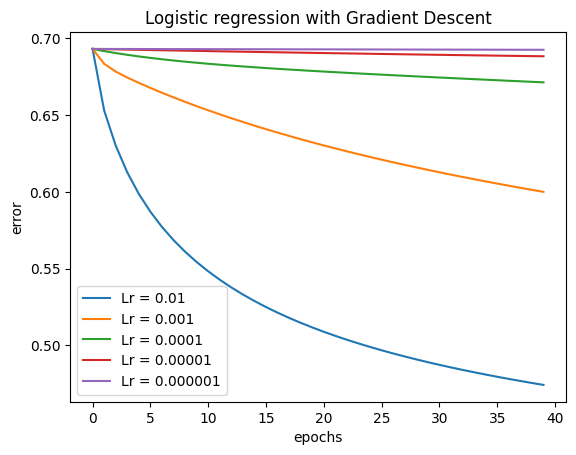

In [306]:
GDs = []
for lr in zip([ 1e-02, 1e-03, 1e-04, 1e-05, 1e-06]):
    d = model(x_train, y_train, x_test, y_test, optimizer = 'GD',
          num_iterations = 2000, learning_rate = lr, print_cost = False)
    GDs.append(d)
    
plotting(GDs, 'Gradient Descent')

/tmp/ipykernel_154228/285226954.py:8: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)
/tmp/ipykernel_154228/285226954.py:8: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)


train accuracy: 88.97973693565588 %
test accuracy: 69.18976545842217 %
train accuracy: 94.34767152506221 %
test accuracy: 70.8955223880597 %
train accuracy: 90.2950586562389 %
test accuracy: 73.2409381663113 %
train accuracy: 86.9178812655528 %
test accuracy: 74.4136460554371 %
train accuracy: 81.83434056167792 %
test accuracy: 76.86567164179104 %


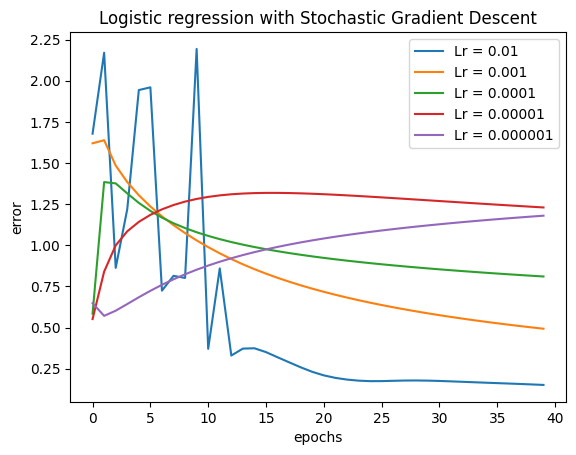

In [309]:
SGDs = []
for lr in zip([1e-01, 1e-02, 1e-03, 1e-04, 1e-05]):
    d = model(x_train, y_train, x_test, y_test, optimizer = 'SGD',
          num_iterations = 2000, learning_rate = lr, print_cost = False)
    SGDs.append(d)
    
plotting(SGDs, 'Stochastic Gradient Descent')

/tmp/ipykernel_178608/285226954.py:8: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)
/tmp/ipykernel_178608/285226954.py:8: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)


train accuracy: 56.66548169214362 %
test accuracy: 55.437100213219615 %
train accuracy: 47.20938499822254 %
test accuracy: 46.58848614072495 %
train accuracy: 83.14966228226093 %
test accuracy: 75.69296375266525 %
train accuracy: 86.5979381443299 %
test accuracy: 73.98720682302772 %
train accuracy: 75.47102737291148 %
test accuracy: 72.60127931769722 %


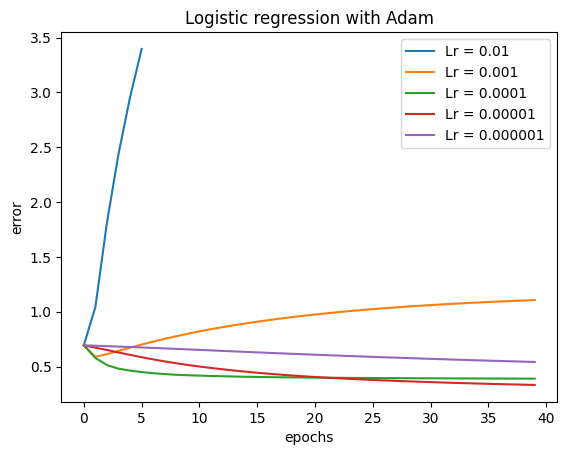

In [12]:
Adams = []
for lr in zip([1e-01, 1e-02, 1e-03, 1e-04, 1e-05]):
    d = model(x_train, y_train, x_test, y_test, optimizer = 'Adam',
          num_iterations = 2000, learning_rate = lr, print_cost = False)
    Adams.append(d)
    
plotting(Adams, 'Adam')

# Conclusion

All three optimization tecniques demonstrate high accuracy (70% and more), however the performance crucially depends on learning rate, amount of epoch and required time. As it may be seen from the plots whereas for SGD and Adam demosntrate inadquate results with lr=0.01, GD has the best performance. 

For the given task the best learning rate values are following:
- GD: 0.1;
- SGD: 0.001;
- Adam: 0.00001.

Besides, as SGD computes gradients iteratively for each row of data, it takes much more training time (in 4-5 times more). Also it may be seen for accuracy outputs, that SGD is the most percise method for the given data, and Adam demostrates the worst performance. 
All methods has a tendency to overfitting, so it's necessary to access the quality of the training on TEST data (there are training cost on plots).

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
